# Blackjack

### Random Action Player

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.47it/s]


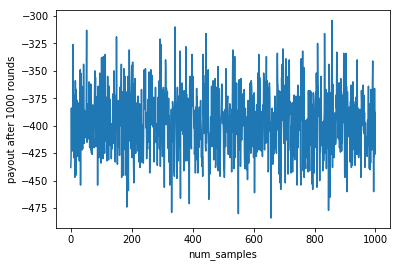

Average payout after 1000 rounds is -396.788


In [1]:
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
env = gym.make('Blackjack-v0')
env.reset()

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

for sample in tqdm(range(num_samples)):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        action = env.action_space.sample()  # take random action
        #print(action) # 0 or 1
        obs, payout, is_done, _ = env.step(action)
        #print(payout)
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

## DQN Agent

In [2]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

class DQN:
    def __init__(self, state_size):
        self.state_size = state_size
        self.memory = deque(maxlen=5000)
        self.discount_rate = 0.95
        self.exploration_rate = 1.0
        self.expRate_min = 0.01
        self.expRate_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(2, activation='softmax'))
        model.compile(loss='binary_crossentropy',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, nxt_state, is_done):
        self.memory.append((state, action, reward, nxt_state, is_done))

    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(2)
        return np.argmax(self.model.predict(state)[0])
    
    def replay(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, nxt_state, is_done in batch:
            tgt = reward
            if not is_done:
                tgt = (reward + self.discount_rate * np.amax(self.model.predict(nxt_state)[0]))
            tgt_fwd = self.model.predict(state)
            tgt_fwd[0][action] = tgt
            self.model.fit(state, tgt_fwd, epochs=1, verbose=0)
        if self.exploration_rate > self.expRate_min:
            self.exploration_rate *= self.expRate_decay

Using TensorFlow backend.


### DQN Player

In [3]:
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from collections import deque

def train():
    env = gym.make('Blackjack-v0')
    state_size = 3
    agent = DQN(state_size)
    is_done = False
    batch_size = 24
    num_epochs = 5000
    # training the DQN
    payout = 0
    scores = []
    for ep in tqdm(range(num_epochs)):
        state = np.reshape(env.reset(), [1, state_size])
        for time in (range(50)):
            action = agent.act(state)
            next_state, reward, is_done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, is_done)
            payout += reward
            scores.append(payout)
            state = next_state
            if is_done:
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
    return agent, scores

agent, scores = train()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:28<00:00, 18.61it/s]


### DQN Evaluation

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:36<00:00,  1.21it/s]


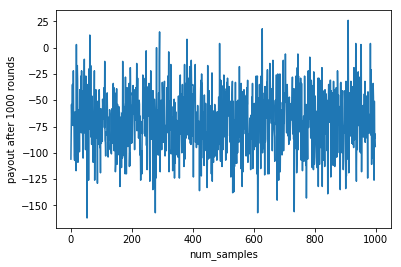

Average payout after 1000 rounds is -69.955


In [7]:
import gym
import matplotlib.pyplot as plt

env = gym.make('Blackjack-v0')
env.reset()
state = np.reshape(env.reset(), [1, 3])
num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

for sample in tqdm(range(num_samples)):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        action = agent.act(state)
        obs, payout, is_done, _ = env.step(action)
        total_payout += payout
        state = np.reshape(obs, [1, 3])
        if is_done:
            env.reset()
            state = np.reshape(env.reset(), [1, 3])
            round += 1
    average_payouts.append(total_payout)

fig = plt.figure()
plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))